### Importing function and setting up dirs

In [1]:
import os
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = "/storage"
base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in os.listdir(base_dir + "/HCP_7T") if len(i) == 6]
base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in os.listdir(base_dir + "/HCP_3T") if len(i) == 6]

path_7t = {}
path_3t = {}



for i in base_dir_7t:
    path_7t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.05.nii.gz" ,"data" : i + "/T1w/Diffusion_7T/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion_7T/bvals" , "bvecs" : i + "/T1w/Diffusion_7T/bvecs"
                      , "brain_mask" : i + "/T1w/Diffusion_7T/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion_7T/grad_dev.nii.gz"}
for i in base_dir_3t:
    path_3t[i[-6:]] = {"3d_scan" : i + "/T1w/T1w_acpc_dc_restore_1.25.nii.gz" , "data" : i + "/T1w/Diffusion/data.nii.gz" 
                       , "bvals" : i + "/T1w/Diffusion/bvals" , "bvecs" : i + "/T1w/Diffusion/bvecs"
                       , "brain_mask" : i + "/T1w/Diffusion/nodif_brain_mask.nii.gz"
                      , "grad_dev" : i + "/T1w/Diffusion/grad_dev.nii.gz"}
    
    
path = {'3T': path_3t, "7T": path_7t}
p = list(path_7t.keys())
q = list(path_3t.keys())
common = list(set(p) & set(q))
common.sort()
print("number of common Subjects ",len(common))

number of common Subjects  171


In [3]:
path_3t[common[0]]

{'3d_scan': '/storage/HCP_3T/100610/T1w/T1w_acpc_dc_restore_1.25.nii.gz',
 'data': '/storage/HCP_3T/100610/T1w/Diffusion/data.nii.gz',
 'bvals': '/storage/HCP_3T/100610/T1w/Diffusion/bvals',
 'bvecs': '/storage/HCP_3T/100610/T1w/Diffusion/bvecs',
 'brain_mask': '/storage/HCP_3T/100610/T1w/Diffusion/nodif_brain_mask.nii.gz',
 'grad_dev': '/storage/HCP_3T/100610/T1w/Diffusion/grad_dev.nii.gz'}

In [4]:
# for i in common:
#     name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
#     print(i,os.path.isfile(name))

### Functions to read the files in nifty

In [13]:
def get_ids():
    return common

def load_hcp(id_load,res,crop = True):
    
    load_from = path[res][id_load]
    
    data,affine = load_nifti(load_from["data"])
    
    mask,affine = load_nifti(load_from["brain_mask"])
    
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    
    gtab = gradient_table(bvals, bvecs)
    
    if(crop):
        maskdata, mask = median_otsu(data, vol_idx=range(0, data.shape[-1]),autocrop=True, dilate=2)
        return maskdata,mask,gtab
    
    return data,mask,gtab
    
def load_gtab(id_load,res):
    load_from = path[res][id_load]
    bvals, bvecs = read_bvals_bvecs(load_from['bvals'], load_from['bvecs'])
    gtab = gradient_table(bvals, bvecs)
    return gtab

### Referred from DeepDTI paper

In [5]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.linalg import eig
from numpy.linalg import inv
from numpy.linalg import pinv
# from numpy.linalg import lstsq
from scipy.linalg import lstsq
from numpy.linalg import solve
from numpy import inf
import numpy as np

import torchio as tio
import SimpleITK as sitk
import skimage.metrics as sm


dsm = np.array([0.91, 0.416, 0,0, 0.91, 0.416,0.416, 0, 0.91,0.91, -0.416, 0,0, 0.91, -0.416,-0.416, 0, 0.91])
dsm = dsm.reshape(6,3)
dsm_norm = np.copy(dsm)
dsm_mag = np.sqrt(dsm[:,0]**2 + dsm[:,1]**2 + dsm[:,2]**2)
for i in range(3):
    dsm_norm[:,i] = dsm[:,i] / dsm_mag

def rot3d(arg):
    x,y,z = arg[0],arg[1],arg[2]
    Rx = np.array([[1 ,0 ,0 ],[0,np.cos(x),-np.sin(x)],[0 ,np.sin(x) ,np.cos(x)]])
    Ry = np.array([[np.cos(y),0 ,np.sin(y) ],[0,1,0],[-np.sin(y),0,np.cos(y)]])
    Rz = np.array([[np.cos(z) ,-np.sin(z) ,0 ],[np.sin(z),np.cos(z),0],[0 ,0,1]])
    R = Rx @ Ry @ Rz
    return R

def amatrix(mat):
    
    a = [mat[:,0] * mat[:,0],2 * mat[:,0] * mat[:,1], 2* mat[:,0] * mat[:,2],
        mat[:,1] * mat[:,1],2 * mat[:,1] * mat[:,2], mat[:,2] * mat[:,2]]
    return np.array(a).T

def optimal_dirs(gtab,num_iter,num_dirs,debug = False,base_bval = 5):
    rotang_all = []
    angerr_all  = []
    condnum_all = []
    ind_all = []
    dirs = np.array(gtab.bvecs[np.where(gtab.bvals != base_bval)[0]])
    for i in range(0,num_iter):
        
        d = np.random.rand(1,3) * 2 * np.pi
        rotang = d[0]
        R = rot3d(rotang)
        dsm_rot = (rot3d(d[0]) @ dsm_norm.T).T
        
        ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))
        minerrors,idx = np.amin(ang_error,1),np.argmin(ang_error,1)

        mean_ang_err = np.mean(np.amin(ang_error,1))
        condnum = np.linalg.cond(amatrix(dirs[idx]))
        
        idx.sort()
        if (mean_ang_err < 5 and condnum < 1.6):
            if ((len(ind_all) == 0 ) or  len(np.where((ind_all == idx).all(axis=1))[0]) == 0 ):
                angerr_all.append(mean_ang_err)
                condnum_all.append(condnum)
                ind_all.append(idx)
                rotang_all.append(rotang)
    condnum_all = np.array(condnum_all)
    indx  = condnum_all.argsort()[:num_dirs]
    if (debug):
        print("Lowest Condition Number : ",condnum_all[indx])
    ind_use = np.array(ind_all)[indx]
    condnum_use = condnum_all[condnum_all.argsort()[:num_dirs]]
    angerr_use = np.array(angerr_all)[indx]
    rotang_use = np.array(rotang_all)[indx]
    return ind_use,condnum_all[indx]




In [6]:
limited_common = common

In [7]:
len(limited_common)

171

In [10]:
limited_common

['100610',
 '102311',
 '102816',
 '104416',
 '105923',
 '108323',
 '109123',
 '111312',
 '111514',
 '114823',
 '115017',
 '115825',
 '116726',
 '118225',
 '125525',
 '126426',
 '128935',
 '130114',
 '130518',
 '131722',
 '132118',
 '134627',
 '134829',
 '135124',
 '137128',
 '140117',
 '144226',
 '145834',
 '146129',
 '146432',
 '146735',
 '146937',
 '148133',
 '155938',
 '156334',
 '157336',
 '158035',
 '158136',
 '159239',
 '162935',
 '164131',
 '164636',
 '165436',
 '167036',
 '167440',
 '169040',
 '169343',
 '169444',
 '169747',
 '171633']

### Normalization 

In [22]:
import torchio as tio
transform = tio.transforms.RescaleIntensity(masking_method=lambda x: x > 0)

## 3T dump

In [8]:
def resampler(data,idx,b0):
    resampled_img = []
    resampled_img.append(data[:,:,:,int(b0)])
    for i in idx:
        resampled_img.append(data[:,:,:,int(i)])
    data = np.stack(resampled_img, axis=3)
    return data

In [9]:
shape_file = {}
shape_file_7t = {}

In [14]:
for i in limited_common:
    name = "/storage/HCP_3T/" + i + "/" + i + ".h5"
    if(not os.path.isfile(name) or True):
        print("Current ID",i)
        
        data,mask,gtab = load_hcp(i,'3T')
        
        hf = h5py.File(name, 'w')
        
        idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))

        idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]

        for j in range(1):
            sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
            ## picking one base bval volume randomly from the data
            sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]
            
            ## picking the bvals,bvecs and corresponding vols from the data 
            bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
            bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
            data6 = resampler(data,idx[j],sample)
            data6 = transform(data6)
            shape_file[i] = (data6.shape)
            hf.create_dataset('volumes'+ str(j), data=data6)
            hf.create_dataset('bvals'+ str(j), data=bvals6)
            hf.create_dataset('bvecs'+ str(j), data=bvecs6)

        hf.create_dataset('idx', data=idx)
        hf.create_dataset('cond', data=cond)
        hf.create_dataset('mask', data=mask)

        hf.close()

        print(name,"Done")

        

Current ID 100610


/tmp/ipykernel_37643/3393162375.py:55: RuntimeWarning: invalid value encountered in arccos
  ang_error = np.degrees(np.arccos(abs(dsm_rot @ dirs.T)))


Lowest Condition Number :  [1.41846062 1.42238217 1.42797114 1.44295595 1.45020355]
/storage/HCP_3T/100610/100610.h5 Done
Current ID 102311
Lowest Condition Number :  [1.4100451  1.42610658 1.43240749 1.43492422 1.44124793]
/storage/HCP_3T/102311/102311.h5 Done
Current ID 102816
Lowest Condition Number :  [1.42877526 1.4545913  1.46128242 1.47365569 1.47559973]
/storage/HCP_3T/102816/102816.h5 Done
Current ID 104416
Lowest Condition Number :  [1.42894449 1.4325308  1.43487568 1.45302373 1.45351373]
/storage/HCP_3T/104416/104416.h5 Done
Current ID 105923
Lowest Condition Number :  [1.42135102 1.42417912 1.43586124 1.43906316 1.44036295]
/storage/HCP_3T/105923/105923.h5 Done
Current ID 108323
Lowest Condition Number :  [1.43510057 1.43997959 1.45280751 1.4601656  1.46373223]
/storage/HCP_3T/108323/108323.h5 Done
Current ID 109123
Lowest Condition Number :  [1.4287443  1.42986092 1.43173914 1.43561777 1.43590097]
/storage/HCP_3T/109123/109123.h5 Done
Current ID 111312
Lowest Condition Num

In [15]:
hf.close()

In [26]:
len(shape_file)

122

In [27]:
len(limited_common)

122

### 7T dump

In [ ]:
for i in common:
    name = "/storage/HCP_7T/" + i + "/" + i + ".h5"
    if(not os.path.isfile(name) or True):
        print("Current ID",i)
        
        data,mask,gtab = load_hcp(i,'7T')
        
        hf = h5py.File(name, 'w')
        
        idx,cond= optimal_dirs(gtab,10000,5,debug = True,base_bval = int(min(gtab.bvals)))

        idx = np.where(gtab.bvals>int(min(gtab.bvals)))[0][idx]

        for j in range(1):
            sample = np.random.randint(0,len(np.where(gtab.bvals==int(min(gtab.bvals)))[0]))
            ## picking one base bval volume randomly from the data
            sample = np.where(gtab.bvals==int(min(gtab.bvals)))[0][sample]
            
            ## picking the bvals,bvecs and corresponding vols from the data 
            bvals6 = np.insert(gtab.bvals[idx[j]],0,gtab.bvals[sample])
            bvecs6 = np.insert(gtab.bvecs[idx[j]],0,gtab.bvecs[sample],axis = 0)
            data6 = resampler(data,idx[j],sample)
            data6 = transform(data6)
            shape_file_7t[i] = (data6.shape)
            hf.create_dataset('volumes'+ str(j), data=data6)
            hf.create_dataset('bvals'+ str(j), data=bvals6)
            hf.create_dataset('bvecs'+ str(j), data=bvecs6)

        hf.create_dataset('idx', data=idx)
        hf.create_dataset('cond', data=cond)
        hf.create_dataset('mask', data=mask)

        hf.close()

        print(name,"Done")

        

In [31]:
hf.close()

## Post Processing

In [15]:
def get_output(data,gtab,mask):
    
    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(data,mask=mask)
    tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
    FA = fractional_anisotropy(tenfit.evals)
    MD = dti.mean_diffusivity(tenfit.evals)
    FA[np.isnan(FA)] = 0
    FA = np.clip(FA, 0, 1)
    RGB = color_fa(FA, tenfit.evecs)
    return RGB,FA,MD,tensor_vals

## Code for preprocessing at 3T

In [ ]:
shape_file = {}

In [ ]:
for i in common:
    name = "/storage/HCP_3T/" + i + "/" + i + "_GT.h5"
    if(not os.path.isfile(name) or True):
        
        print("Current ID",i)
        
        data,mask,gtab  = load_hcp(i,'3T')
        
#         data = transform(data)
        shape_file[i] = (data.shape)
        
        hf = h5py.File(name, 'w')
        
        r,f,md,ten_vals = get_output(data,gtab,mask)

        hf.create_dataset('tensor_vals', data=ten_vals)
        hf.create_dataset('ADC', data=transform(np.expand_dims(md,axis =3)))
        hf.create_dataset('FA', data=transform(np.expand_dims(f,axis =3)))
        hf.create_dataset('color_FA', data=transform(r))

        hf.close()
        print(name,"Done")

## Code for preprocessing at 7T

In [25]:
shape_file_7t = {}

In [ ]:
for i in common:
    name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
    if(not os.path.isfile(name) or True):
        
        print("Current ID",i)
        
        data_7t,mask_7t,gtab_7t  = load_hcp(i,'7T')
        
#         data_7t = transform(data_7t)
        shape_file_7t[i] = (data_7t.shape)
        
        hf = h5py.File(name, 'w')
        
        r,f,md,ten_vals = get_output(data_7t,gtab_7t,mask_7t)

        hf.create_dataset('tensor_vals', data=ten_vals)
        hf.create_dataset('ADC', data=transform(np.expand_dims(md,axis =3)))
        hf.create_dataset('FA', data=transform(np.expand_dims(f,axis =3)))
        hf.create_dataset('color_FA', data=transform(r))

        hf.close()
        print(name,"Done")

Current ID 100610
/storage/HCP_7T/100610/100610_GT.h5 Done
Current ID 102311


In [24]:
hf.close()

In [33]:
len(shape_file_7t)

171

In [34]:
len(shape_file)

171

In [39]:
shapes = [(shape_file[i],shape_file_7t[i],[shape_file[i][j]/shape_file_7t[i][j] for j in range(3) ]) for i in common]

In [48]:
shapes[:]

[((113, 147, 107, 288),
  (133, 177, 113, 143),
  [0.849624060150376, 0.8305084745762712, 0.9469026548672567]),
 ((108, 141, 101, 288),
  (128, 170, 122, 143),
  [0.84375, 0.8294117647058824, 0.8278688524590164]),
 ((109, 137, 107, 288),
  (128, 165, 128, 143),
  [0.8515625, 0.8303030303030303, 0.8359375]),
 ((105, 135, 109, 288),
  (124, 159, 132, 143),
  [0.8467741935483871, 0.8490566037735849, 0.8257575757575758]),
 ((111, 142, 108, 288),
  (133, 170, 130, 143),
  [0.8345864661654135, 0.8352941176470589, 0.8307692307692308]),
 ((109, 134, 103, 288),
  (130, 161, 131, 143),
  [0.8384615384615385, 0.8322981366459627, 0.7862595419847328]),
 ((110, 146, 114, 288),
  (130, 175, 139, 143),
  [0.8461538461538461, 0.8342857142857143, 0.8201438848920863]),
 ((102, 133, 102, 288),
  (121, 159, 124, 143),
  [0.8429752066115702, 0.8364779874213837, 0.8225806451612904]),
 ((113, 146, 111, 288),
  (134, 175, 132, 143),
  [0.8432835820895522, 0.8342857142857143, 0.8409090909090909]),
 ((106, 143, 

## Analysis of Dump

In [24]:
import os
from dipy.segment.mask import median_otsu
from dipy.reconst.dti import fractional_anisotropy, color_fa
import dipy.reconst.dti as dti
import h5py
import matplotlib.pyplot as plt

In [27]:
for i in limited_common:
    name = "/storage/HCP_7T/" + i + "/" + i + "_GT.h5"
    hf = h5py.File(name, 'r')
    shape_file_7t[i] = np.array(hf.get("ADC")).shape

In [28]:
shape_file_7t

{'172130': (),
 '173334': (173, 207, 173),
 '175237': (173, 207, 173),
 '176542': (173, 207, 173),
 '177140': (173, 207, 173),
 '177645': (173, 207, 173),
 '177746': (173, 207, 173),
 '178142': (173, 207, 173),
 '178243': (173, 207, 173),
 '178647': (173, 207, 173),
 '180533': (173, 207, 173),
 '181232': (173, 207, 173),
 '182436': (173, 207, 173),
 '182739': (173, 207, 173),
 '185442': (173, 207, 173),
 '187345': (173, 207, 173),
 '191033': (173, 207, 173),
 '191336': (173, 207, 173),
 '191841': (173, 207, 173),
 '192439': (173, 207, 173),
 '192641': (173, 207, 173),
 '193845': (173, 207, 173),
 '195041': (173, 207, 173),
 '196144': (173, 207, 173),
 '197348': (173, 207, 173),
 '198653': (173, 207, 173),
 '199655': (173, 207, 173),
 '200210': (173, 207, 173),
 '200311': (173, 207, 173),
 '200614': (173, 207, 173),
 '201515': (173, 207, 173),
 '203418': (173, 207, 173),
 '204521': (173, 207, 173),
 '205220': (173, 207, 173),
 '209228': (173, 207, 173),
 '212419': (173, 207, 173),
 '214

In [24]:
name = "/storage/HCP_7T/" + common[0] + "/" + common[0] + "_GT.h5"
hf = h5py.File(name, 'r')
name = "/storage/HCP_3T/" + common[0] + "/" + common[0] + ".h5"
hf_lr = h5py.File(name, 'r')

In [25]:
name

'/storage/HCP_3T/100610/100610.h5'

In [26]:
import numpy as np

In [38]:
t3= {}

In [39]:
for i in list(hf_lr.keys()):
    print(i,np.array(hf_lr.get(i)).shape)
    t3[i] = np.array(hf_lr.get(i))

bvals0 (7,)
bvecs0 (7, 3)
cond (5,)
idx (5, 6)
mask (113, 147, 107)
volumes0 (113, 147, 107, 7)


In [32]:
t7 = {}

In [33]:
for i in list(hf.keys()):
    print(i,np.array(hf.get(i)).shape)
    t7[i] = np.array(hf.get(i))

ADC (133, 177, 113)
FA (133, 177, 113)
color_FA (133, 177, 113, 3)
tensor_vals (133, 177, 113, 6)


In [48]:

plt.rcParams['figure.figsize'] = [20, 20]

In [58]:
scale = [t7['ADC'].shape[i]/t3['volumes0'].shape[i] for i in range(3)]

In [59]:
scale

[1.176991150442478, 1.2040816326530612, 1.0560747663551402]

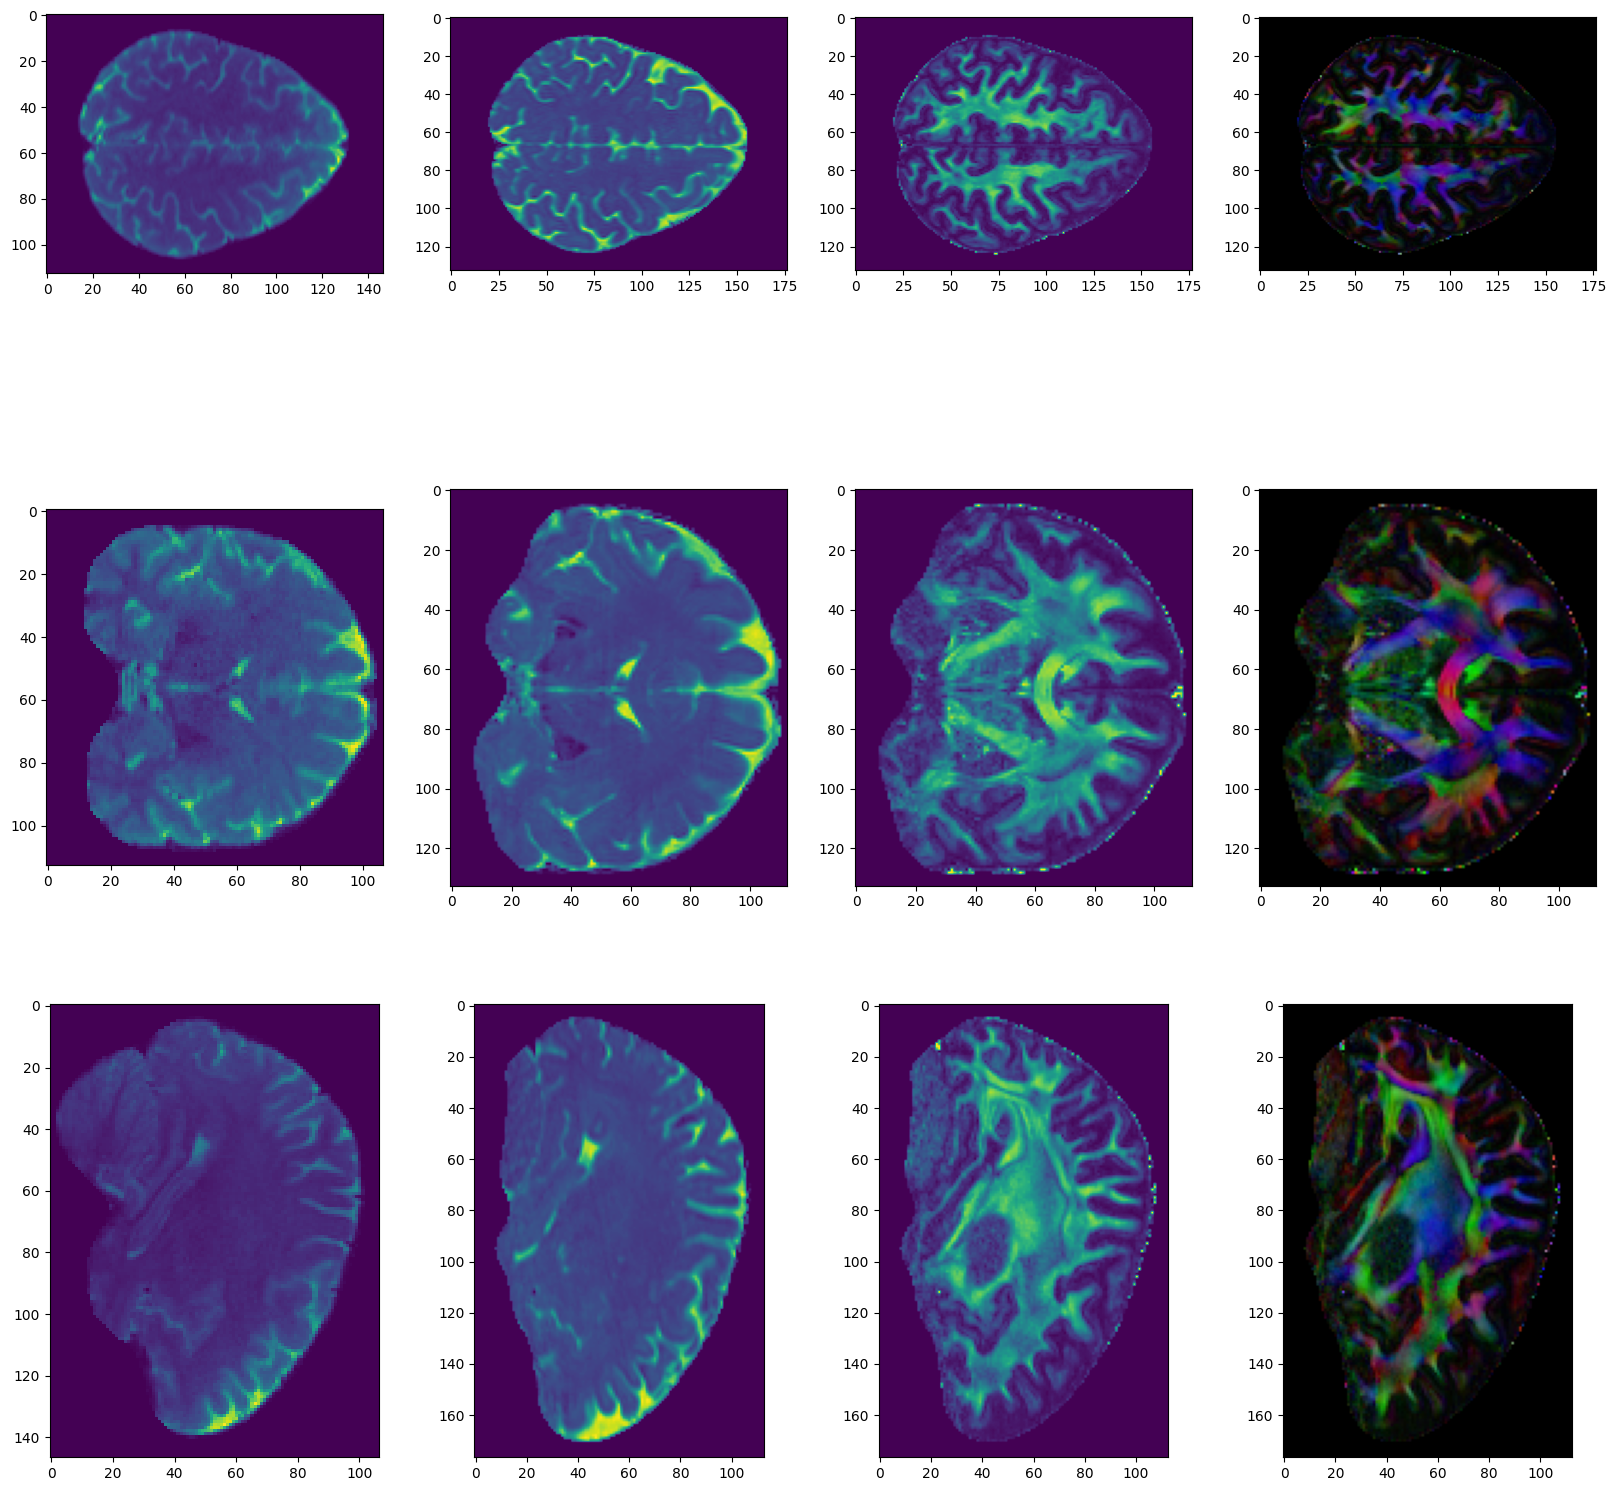

In [74]:
fig,ax = plt.subplots(3,4)
sli =80
ax[0][0].imshow(t3['volumes0'][:,:,sli,0])
ax[0][1].imshow(t7['ADC'][:,:,int(sli*scale[2])])
ax[0][2].imshow(t7['FA'][:,:,int(sli*scale[2])])
ax[0][3].imshow(t7['color_FA'][:,:,int(sli*scale[2]),:])


ax[1][0].imshow(t3['volumes0'][:,sli,:,0])
ax[1][1].imshow(t7['ADC'][:,int(sli*scale[1]),:])
ax[1][2].imshow(t7['FA'][:,int(sli*scale[1]),:])
ax[1][3].imshow(t7['color_FA'][:,int(sli*scale[1]),:,:])


ax[2][0].imshow(t3['volumes0'][sli,:,:,0])
ax[2][1].imshow(t7['ADC'][int(sli*scale[0]),:,:])
ax[2][2].imshow(t7['FA'][int(sli*scale[0]),:,:])
ax[2][3].imshow(t7['color_FA'][int(sli*scale[0]),:,:,:])
# ax[0].imshow(t7['ADC'][:,:,40])

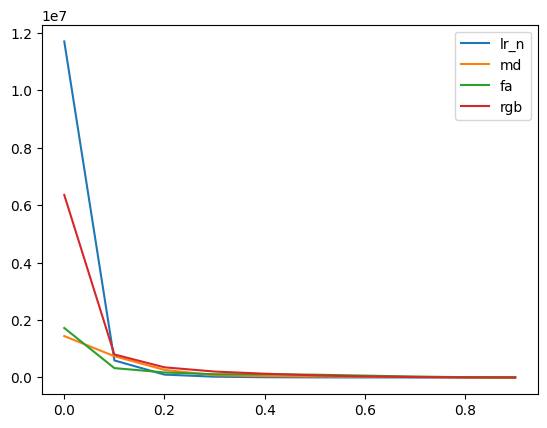

In [29]:
%matplotlib inline
hist,bins = {},{}
# hist['lr'],bins['lr'] = np.histogram(norm(np.array(hf_lr.get('volumes0'))))
hist['lr_n'],bins['lr_n'] = np.histogram(transform(np.array(hf_lr.get('volumes0'))))
hist['md'],bins['md'] = np.histogram(transform(np.expand_dims(np.array(hf.get("ADC")),axis=0)))
# hist['adc'],bins['adc'] = np.histogram(transform(np.expand_dims(MD,axis=0)))

hist['fa'],bins['fa'] = np.histogram(transform(np.expand_dims(np.array(hf.get("FA")),axis=0)))
hist['rgb'],bins['rgb'] = np.histogram(transform(np.array(hf.get("color_FA"))))

for i in hist.keys():
    plt.plot(bins[i][:-1],hist[i],label=i)
plt.legend()

In [ ]:
for i in hist.keys():
    plt.plot(bins[i][:-1],hist[i],label=i)
plt.legend()

In [ ]:
plt.plot(bins['hr'][:-1], hist['hr'],label="all vols")

# plt.plot(bins['hr6'][1:-1], hist['hr6'][1:],label="6 vols")

plt.plot(bins['hr6_mask'][:-1], hist['hr6_mask'],label="data_masked")

# plt.yscale("log")
plt.legend()
plt.grid()

In [ ]:
np.array(hf.get('idx'))

In [ ]:
np.array(hf.get('bvals0'))

In [ ]:
plt.imshow(np.array(hf.get('volumes0'))[:,:,20,6])

In [ ]:
for i in list(hf_lr.keys()):
    print(i,np.array(hf_lr.get(i)).shape)

In [ ]:
np.array(hf_lr.get('bvals0'))

In [ ]:
i=70
f, axis = plt.subplots(1, 2)
f.set_figwidth(20)
f.set_figheight(10)
temp = np.transpose(hf_lr.get('mask'), (2,1,0))
# temp = np.fliplr(np.rot90(hf_lr.get('volumes0')[i,:,:,0],k=3))
axis[0].imshow(hf_lr.get('volumes0')[:,:,i,0])
axis[1].set_title('FA "fractional anisotropy"')
axis[1].imshow(np.array(hf.get('volumes0'))[:,:,i,0])
# axis[2].set_title('MD "Mean Diffusivity or Average Diffusion Coefficent(ADC)"')
# axis[2].imshow(np.array(hf.get('ADC'))[:,:,i])
# axis[3].set_title('MD_RGB "Principal Diffusion Directions"')
# axis[3].imshow(np.array(hf.get('color_FA'))[:,:,i])

In [ ]:
np.array(hf.get('ADC')).max(),np.array(hf.get('ADC')).min()

In [ ]:
np.array(hf.get('FA')).max(),np.array(hf.get('FA')).min()

In [ ]:
np.array(hf.get('color_FA')).max(),np.array(hf.get('color_FA')).min()

In [ ]:
i=70
f, axis = plt.subplots(1, 3)
f.set_figwidth(20)
f.set_figheight(10)
axis[0].set_title('FA "fractional anisotropy"')
axis[0].imshow(np.array(hf.get('FA'))[:,:,i])
axis[1].set_title('MD "Mean Diffusivity or Average Diffusion Coefficent(ADC)"')
axis[1].imshow(np.array(hf.get('ADC'))[:,:,i])
axis[2].set_title('MD_RGB "Principal Diffusion Directions"')
axis[2].imshow(np.array(hf.get('color_FA'))[:,:,i])
# plt.colorbar()

In [ ]:
plt.imshow(np.array(hf.get('FA'))[:,:,i])
plt.colorbar()

In [ ]:
np.array(hf.get('ADC')).max(),np.array(hf.get('ADC')).min()